# New Section

### import lib drive and load data mock up

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/com7_cradit_scoring/Ai monitoring/mock_y_pred_m0.csv")
df2 = pd.read_csv("/content/drive/MyDrive/com7_cradit_scoring/Ai monitoring/mock_y_pred_m1.csv")


In [ ]:
df2["0"].head()

0    0.395941
1    0.418465
2    0.532758
3    0.522753
4    0.472842
Name: 0, dtype: float64

In [ ]:
df2.columns

Index(['Unnamed: 0', '0'], dtype='object')

In [ ]:
df2_bi = np.where(df2["0"].values > 0.5, 1, 0)
df1_bi = np.where(df1["0"].values > 0.5, 1, 0)
print(df2_bi)

[0 0 1 ... 1 0 0]


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = df2_bi
y_true = df1_bi
accuracy_score(y_true, y_pred)
# accuracy_score(y_true, y_pred, normalize=False)

0.4947

In [ ]:
# Check for performance degradation
acceptable_accuracy_threshold = 0.7
production_accuracy = 0.4947

if production_accuracy < acceptable_accuracy_threshold:
    print("Accuracy degradation detected!")
    # investigate_accuracy_degradation(production_data, production_labels)

Accuracy degradation detected!


## Relative accuracy percentage = (Absolute error / True value) * 100%

In [ ]:
def calculate_relative_accuracy_percentage(true_values, predictions):
    relative_accuracy_percentages = []
    for true_value, prediction in zip(true_values, predictions):
        absolute_error = abs(true_value - prediction)
        relative_accuracy_percentage = (absolute_error / true_value) * 1.0
        relative_accuracy_percentages.append(relative_accuracy_percentage)
    return relative_accuracy_percentages

In [ ]:
true_values = [0.7, 0.8, 0.6, 0.65, 0.77] # month zero????
# month 1 - month 5
# true_values = df2_bi

In [ ]:
predictions = [0.6, 0.7, 0.6, 0.6, 0.75]
# predictions = df1_bi

In [ ]:
0.1/0.7

0.14285714285714288

In [ ]:
history_acc = calculate_relative_accuracy_percentage(true_values, predictions)
history_acc

[0.14285714285714282,
 0.1250000000000001,
 0.0,
 0.07692307692307698,
 0.025974025974025997]

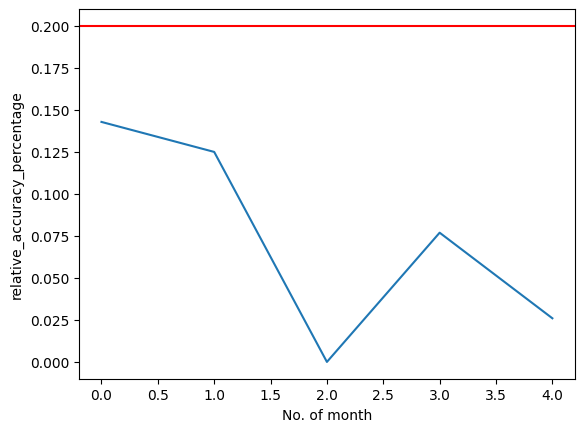

In [ ]:
acceptable_accuracy_threshold = 0.20

plt.plot(history_acc)
plt.axhline(y=acceptable_accuracy_threshold, color='r', linestyle='-')
plt.ylabel("relative_accuracy_percentage")
plt.xlabel("No. of month")
plt.show()

## in pyspark

In [ ]:
!pip install pyspark==3.1.1
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz

!pip install -q findspark
import findspark
findspark.init() #locate Spark on the system and import it as a regular library

import os, sys
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 19.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767582 sha256=894cad7e777b8e0bf8a3362d47c4fd3f23768a95d3d55fcb5d2f934094335547
  Stored in directory: /root/.cache/pip/wheels/a0/3f/72/8efd988f9ae041f051c75e6834cd92dd6d13a726e206e8b6f3
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType

def calculate_relative_accuracy_percentage_udf(true_value, prediction):
    absolute_error = abs(true_value - prediction)
    relative_accuracy_percentage = (absolute_error / true_value) * 1.0
    return relative_accuracy_percentage

# Create a UDF for calculating relative accuracy percentage
relative_accuracy_percentage_udf = udf(calculate_relative_accuracy_percentage_udf, FloatType())

# Apply the UDF to a DataFrame containing true values and predictions
df = spark.createDataFrame([(100, 95), (50, 40), (200, 180)], ["true_value", "prediction"])

# Calculate relative accuracy percentage for each row
relative_accuracy_percentages = df.withColumn("relative_accuracy_percentage", relative_accuracy_percentage_udf(col("true_value"), col("prediction")))

# Display the results
relative_accuracy_percentages.show()

+----------+----------+----------------------------+
|true_value|prediction|relative_accuracy_percentage|
+----------+----------+----------------------------+
|       100|        95|                        0.05|
|        50|        40|                         0.2|
|       200|       180|                         0.1|
+----------+----------+----------------------------+



## Rank ordering

In [ ]:
import pandas as pd

def calculate_rank_ordering_df(df, column_name):
    """
    Calculates the rank ordering for a given DataFrame and column.

    Args:
        df: A Pandas DataFrame.
        column_name: The name of the column to calculate rank ordering for.

    Returns:
        A Pandas DataFrame with an additional column named 'rank_ordering'.
    """
    # Sort the DataFrame by the specified column in descending order
    sorted_df = df.sort_values(by=column_name, ascending=False)

    # Create a dictionary to map data points to their rank orderings
    rank_orderings = {}
    for i, row in sorted_df.iterrows():
        rank_orderings[row[column_name]] = i + 1

    # Add a new column named 'rank_ordering' to the DataFrame
    sorted_df['rank_ordering'] = sorted_df[column_name].apply(lambda x: rank_orderings[x])

    return sorted_df

# Example usage
data = {'name': ['Alice', 'Bob', 'Charlie', 'David', 'Emily'], 'score': [90, 85, 75, 65, 55]}
df = pd.DataFrame(data)

# Calculate rank ordering for the 'score' column
df_with_rank_ordering = calculate_rank_ordering_df(df, 'score')

print(df_with_rank_ordering)

## Bootstrap-confidence-intervals

use y proba



The choice of the most appropriate statistic for bootstrap resampling in machine learning model monitoring depends on the specific metric or characteristic you want to assess. Here are some common statistics used in bootstrap resampling for different purposes:

1. Evaluating model performance distribution:

If you're interested in understanding the overall distribution of model performance, such as accuracy, precision, recall, or F1 score, using the mean statistic is appropriate. The mean provides an average measure of performance across bootstrap samples.

2. Identifying performance outliers:

To detect unusual or outlying performance values, consider using the median statistic. The median is less sensitive to outliers compared to the mean, making it suitable for identifying extreme cases.

3. Assessing model sensitivity to data drift:

When evaluating model sensitivity to data drift, the standard deviation statistic can be used to quantify the variability of performance across bootstrap samples. A larger standard deviation indicates that the model's performance is more sensitive to changes in the data distribution.

4. Monitoring model calibration:

For classification tasks, the Brier score can be used to assess model calibration. The Brier score measures the average squared difference between the model's predicted probabilities and the actual class labels. A lower Brier score indicates better calibration.

5. Detecting concept drift:

To detect concept drift, consider using the Kolmogorov-Smirnov statistic. This statistic measures the distance between the distribution of performance metrics for two sets of bootstrap samples, one from the current data and the other from a reference period. A significant increase in the Kolmogorov-Smirnov statistic suggests concept drift.

In addition to these specific statistics, bootstrap resampling can also be used to estimate confidence intervals for various model performance metrics, providing a range of plausible values for the metric. This helps in understanding the uncertainty associated with the model's performance.

In [ ]:
import numpy as np
from scipy.stats import bootstrap

def calculate_bootstrap_confidence_intervals(data, statistic, num_bootstraps=1000, alpha=0.05):
    """
    Calculates bootstrap confidence intervals for a given statistic.

    Args:
        data: The data to be bootstrapped.
        statistic: The statistic to be calculated.
        num_bootstraps: The number of bootstrap samples to draw.
        alpha: The confidence level (e.g., 0.05 for 95% confidence intervals).

    Returns:
        A tuple containing the lower and upper bounds of the confidence interval.
    """
    # Calculate the statistic on the original data
    original_statistic = statistic(data)

    # Create bootstrap samples
    bootstrapped_samples = []
    for _ in range(num_bootstraps):
        bootstrapped_sample = np.random.choice(data, replace=True, size=len(data))
        bootstrapped_samples.append(bootstrapped_sample)

    # Calculate the statistic on each bootstrap sample
    bootstrapped_statistics = []
    for sample in bootstrapped_samples:
        bootstrapped_statistics.append(statistic(sample))

    # Sort the bootstrapped statistics
    sorted_bootstrapped_statistics = sorted(bootstrapped_statistics)

    # Determine the lower and upper bounds of the confidence interval
    lower_bound = sorted_bootstrapped_statistics[int(alpha * len(bootstrapped_statistics))]
    upper_bound = sorted_bootstrapped_statistics[-int(alpha * len(bootstrapped_statistics))]

    return lower_bound, upper_bound

# Example usage
def calculate_mean(data):
    return np.mean(data)

data = np.array([10, 12, 14, 15, 16])
lower_bound, upper_bound = calculate_bootstrap_confidence_intervals(data, calculate_mean, num_bootstraps=1000, alpha=0.05)

print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)


Lower bound: 11.8
Upper bound: 15.0
